<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/LEAR_Easy_recalibration_Bridging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Quantile regression

C:\Users\Gams_Benamor\AppData\Local\Temp\4\ipykernel_26784\947057893.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_dates = pd.date_range(start=test_start, end=test_end, freq='H')


MAE: 10.299706378918874
MSE: 161.61120593666095
RMSE: 12.712639613261322
Mean CRPS: 9.21457496761972


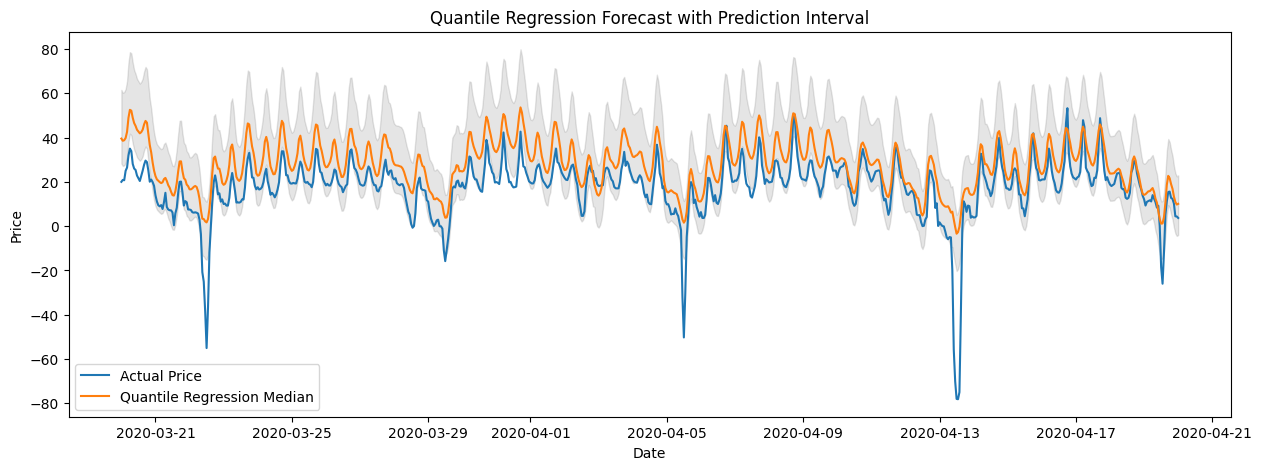

In [17]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm

# Load the data from the Excel file
file_path = r'C:\Users\Gams_Benamor\Desktop\German_EPF.xlsx'
data = pd.read_excel(file_path, index_col=0, parse_dates=True)

# Define the exogenous variables
exog_cols = ['Load_DA_Forecast', 'Renewables_DA_Forecast']

# Define the calibration and test periods
calibration_window_hours = 4 * 365 * 24  # 4 years
test_start = '2020-03-20'
test_end = '2020-04-20'  # Reduced test period for quick execution
test_dates = pd.date_range(start=test_start, end=test_end, freq='H')

# Function to calculate mean CRPS
def mean_crps(y_true, y_pred, y_pred_lower, y_pred_upper):
    """Calculate the mean Continuous Ranked Probability Score (CRPS)."""
    crps = []
    for yt, yp, yl, yu in zip(y_true, y_pred, y_pred_lower, y_pred_upper):
        z = (yt - yp) / (yu - yl)
        crps_value = (yu - yl) * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1/np.sqrt(np.pi))
        crps.append(crps_value)
    return np.mean(crps)

# Store predictions and actuals
predictions_median = []
predictions_lower = []
predictions_upper = []
actuals = []

# Moving calibration window
for test_date in test_dates:
    calibration_end_date = test_date - pd.DateOffset(hours=1)
    calibration_start_date = calibration_end_date - pd.DateOffset(hours=calibration_window_hours)

    # Extract the calibration and test data
    train_data = data[(data.index >= calibration_start_date) & (data.index <= calibration_end_date)]
    test_data = data[data.index == test_date]

    if len(test_data) == 0:
        continue

    # Prepare the training and test data
    X_train = train_data[exog_cols].values
    y_train = train_data['Price'].values
    X_test = test_data[exog_cols].values
    y_test = test_data['Price'].values

    # Normalize the target variable
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    # Prepare data for quantile regression
    X_train_with_const = sm.add_constant(X_train)
    X_test_with_const = sm.add_constant(X_test, has_constant='add')

    # Fit quantile regression models for different quantiles
    quantiles = [0.5, 0.05, 0.95]
    predictions = {}
    for q in quantiles:
        model = sm.QuantReg(y_train, X_train_with_const)
        results = model.fit(q=q)
        predictions[q] = results.predict(X_test_with_const)

    # Extract predictions
    y_pred_median = predictions[0.5]
    y_pred_lower = predictions[0.05]
    y_pred_upper = predictions[0.95]

    # Inverse transform predictions to original scale
    y_pred_median_inv = scaler_y.inverse_transform(y_pred_median.reshape(-1, 1))
    y_pred_lower_inv = scaler_y.inverse_transform(y_pred_lower.reshape(-1, 1))
    y_pred_upper_inv = scaler_y.inverse_transform(y_pred_upper.reshape(-1, 1))
    y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    # Store predictions and actuals
    predictions_median.append(y_pred_median_inv.flatten()[0])
    predictions_lower.append(y_pred_lower_inv.flatten()[0])
    predictions_upper.append(y_pred_upper_inv.flatten()[0])
    actuals.append(y_test_inv.flatten()[0])

# Remove any NaN values from the lists
predictions_median = np.array(predictions_median)
predictions_lower = np.array(predictions_lower)
predictions_upper = np.array(predictions_upper)
actuals = np.array(actuals)

valid_idx = ~np.isnan(predictions_median) & ~np.isnan(predictions_lower) & ~np.isnan(predictions_upper) & ~np.isnan(actuals)
predictions_median = predictions_median[valid_idx]
predictions_lower = predictions_lower[valid_idx]
predictions_upper = predictions_upper[valid_idx]
actuals = actuals[valid_idx]

# Calculate evaluation metrics
mae = mean_absolute_error(actuals, predictions_median)
mse = mean_squared_error(actuals, predictions_median)
rmse = np.sqrt(mse)
mean_crps_value = mean_crps(np.array(actuals), np.array(predictions_median), np.array(predictions_lower), np.array(predictions_upper))

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Mean CRPS: {mean_crps_value}")

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(test_dates[:len(actuals)], actuals, label='Actual Price')
plt.plot(test_dates[:len(predictions_median)], predictions_median, label='Quantile Regression Median')
plt.fill_between(test_dates[:len(predictions_lower)], predictions_lower, predictions_upper, color='k', alpha=0.1)
plt.title('Quantile Regression Forecast with Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Results saved to C:\Users\Gams_Benamor\Desktop\quantile_regression_results.xlsx
Plot saved to C:\Users\Gams_Benamor\Desktop\quantile_regression_plot.png


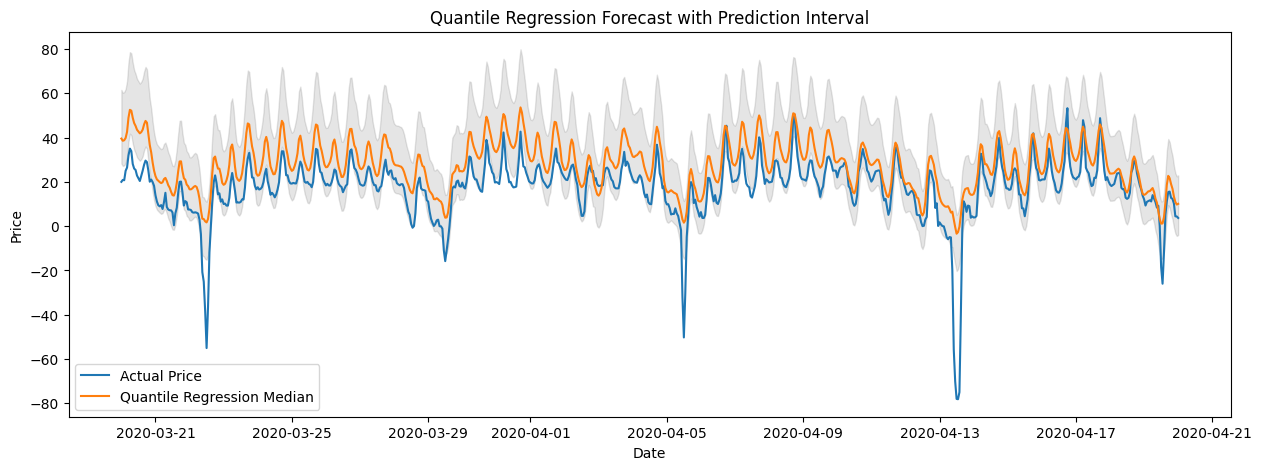

In [18]:
# Save results to Excel
results_df = pd.DataFrame({
    'Date': test_dates[:len(actuals)],
    'Actual': actuals,
    'Median Prediction': predictions_median,
    'Lower Prediction': predictions_lower,
    'Upper Prediction': predictions_upper
})

excel_file_path = r'C:\Users\Gams_Benamor\Desktop\quantile_regression_results.xlsx'
results_df.to_excel(excel_file_path, index=False)

print(f"Results saved to {excel_file_path}")

# Save plot to image file
plot_file_path =r'C:\Users\Gams_Benamor\Desktop\quantile_regression_plot.png'
plt.figure(figsize=(15, 5))
plt.plot(test_dates[:len(actuals)], actuals, label='Actual Price')
plt.plot(test_dates[:len(predictions_median)], predictions_median, label='Quantile Regression Median')
plt.fill_between(test_dates[:len(predictions_lower)], predictions_lower, predictions_upper, color='k', alpha=0.1)
plt.title('Quantile Regression Forecast with Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig(plot_file_path)

print(f"Plot saved to {plot_file_path}")

CRU

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

# Load the data from the Excel file
file_path = r'C:\Users\Gams_Benamor\Desktop\German_EPF.xlsx'
data = pd.read_excel(file_path, index_col=0, parse_dates=True)

# Define the exogenous variables
exog_cols = ['Load_DA_Forecast', 'Renewables_DA_Forecast']

# Define the calibration and test periods
calibration_window_hours = 4 * 365 * 24  # 4 years
test_start = '2023-03-20'
test_end = '2023-04-20' # Reduced test period for quick execution
test_dates = pd.date_range(start=test_start, end=test_end, freq='H')

# Function to calculate mean CRPS
def mean_crps(y_true, y_pred, y_pred_lower, y_pred_upper):
    """Calculate the mean Continuous Ranked Probability Score (CRPS)."""
    crps = []
    for yt, yp, yl, yu in zip(y_true, y_pred, y_pred_lower, y_pred_upper):
        z = (yt - yp) / (yu - yl)
        crps_value = (yu - yl) * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1/np.sqrt(np.pi))
        crps.append(crps_value)
    return np.mean(crps)

# Prepare the data for training the GRU model
n_steps = 24  # Number of past hours to use for prediction
X_train_list = []
y_train_list = []
actuals = []
predictions = []
predictions_lower = []
predictions_upper = []

for test_date in test_dates:
    calibration_end_date = test_date - pd.DateOffset(hours=1)
    calibration_start_date = calibration_end_date - pd.DateOffset(hours=calibration_window_hours)
    
    # Extract the calibration and test data
    train_data = data[(data.index >= calibration_start_date) & (data.index <= calibration_end_date)]
    test_data = data[data.index == test_date]
    
    if len(test_data) == 0:
        continue
    
    # Prepare the training and test data
    X_train = train_data[exog_cols].values
    y_train = train_data['Price'].values
    X_test = test_data[exog_cols].values
    y_test = test_data['Price'].values
    
    # Normalize the target variable
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Create sequences for training
    for i in range(len(X_train) - n_steps):
        X_train_list.append(X_train[i:i+n_steps])
        y_train_list.append(y_train[i+n_steps])

# Convert lists to arrays
X_train_array = np.array(X_train_list)
y_train_array = np.array(y_train_list)

# Build the GRU model
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(n_steps, len(exog_cols))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the GRU model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train_array, y_train_array, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict using the trained GRU model
for test_date in test_dates:
    # Extract the test data
    test_data = data[data.index == test_date]
    X_test = test_data[exog_cols].values
    y_test = test_data['Price'].values
    
    if len(test_data) == 0:
        continue
    
    # Normalize the target variable
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Create sequence for prediction
    X_test_seq = np.array([X_test[-n_steps:]])
    
    # Predict
    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    # Calculate residuals from training data
    y_train_pred = model.predict(X_train_array)
    residuals = y_train_array - scaler_y.inverse_transform(y_train_pred)
    std_dev = np.std(residuals)
    
    # Forecast intervals
    z = 1.96  # For 95% confidence interval
    lower_bound = y_pred - z * std_dev
    upper_bound = y_pred + z * std_dev
    
    # Store predictions and actuals
    actuals.append(y_test[0])
    predictions.append(y_pred[0][0])
    predictions_lower.append(lower_bound[0][0])
    predictions_upper.append(upper_bound[0][0])

# Remove any NaN values from the lists
predictions = np.array(predictions)
predictions_lower = np.array(predictions_lower)
predictions_upper = np.array(predictions_upper)
actuals = np.array(actuals)

valid_idx = ~np.isnan(predictions) & ~np.isnan(predictions_lower) & ~np.isnan(predictions_upper) & ~np.isnan(actuals)
predictions = predictions[valid_idx]
predictions_lower = predictions_lower[valid_idx]
predictions_upper = predictions_upper[valid_idx]
actuals = actuals[valid_idx]

# Calculate evaluation metrics
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mean_crps_value = mean_crps(actuals, predictions, predictions_lower, predictions_upper)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Mean CRPS: {mean_crps_value}")

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(test_dates[:len(actuals)], actuals, label='Actual Price')
plt.plot(test_dates[:len(predictions)], predictions, label='GRU Predicted Price')
plt.fill_between(test_dates[:len(predictions_lower)], predictions_lower, predictions_upper, color='k', alpha=0.1)
plt.title('GRU Model Forecast with Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


LSTM-QR

In [12]:
pip install properscoring

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: c:\Program Files\Python311\python.exe -m pip install --upgrade pip


Processing date: 2019-07-20 00:00:00
Training data from 2015-07-20 23:00:00 to 2019-07-19 23:00:00 contains 35041 samples.
X_train shape: (35017, 24, 2), y_train shape: (35017,)
Epoch 1/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.6934 - val_loss: 1.0071
Epoch 2/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.4737 - val_loss: 1.3691
Epoch 3/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.4444 - val_loss: 1.4559
Epoch 4/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.4179 - val_loss: 1.3287
Epoch 5/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.4084 - val_loss: 1.1907
Epoch 6/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.3986 - val_loss: 1.2386
Epoch 7/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.3778 - val_loss: 1.4573
Epoch 8/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.3813 - val_loss: 1.3485
Epoch 9/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.3614 - val_loss: 1.3275
Epoch 10/10
876/876 ━━━━━━━━━━━━━━━━

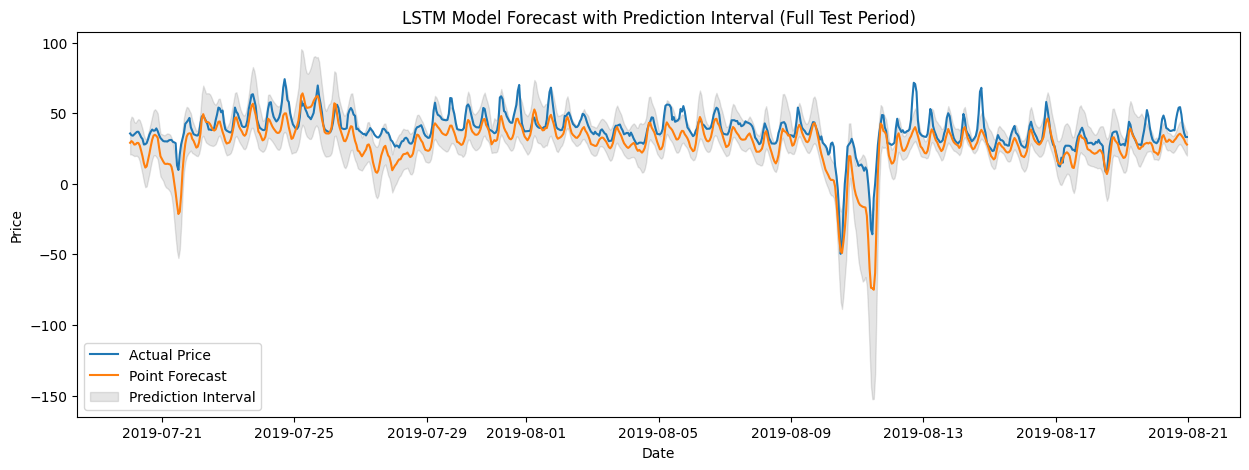

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import properscoring as ps

# Load the data from the Excel file
file_path =  r'C:\Users\Gams_Benamor\Desktop\German_EPF.xlsx'
df = pd.read_excel(file_path)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Handle missing values
df = df.dropna()

# Define the test period
test_start = '2019-07-20'
test_end = '2019-08-20'  # 10-day test period

# Define function to create LSTM dataset
def create_lstm_dataset(data, target_col, exog_cols, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        X.append(data.iloc[i:end_ix][exog_cols].values)
        y.append(data.iloc[end_ix][target_col])
    return np.array(X), np.array(y)

n_steps = 24
exog_cols = ['Load_DA_Forecast', 'Renewables_DA_Forecast']

# Define the tilted loss function for quantile regression
def tilted_loss(q, y, f):
    e = (y - f)
    return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e), axis=-1)

# Define calibration window size (4 years in hours)
calibration_window_hours = 4 * 365 * 24

# Initialize results DataFrame
results_list = []

# Iterate over each day in the test period
test_dates = pd.date_range(start=test_start, end=test_end, freq='D')
for current_date in test_dates:
    print(f'Processing date: {current_date}')
    # Define training period (last 4 years from current date in hours)
    train_end = current_date - pd.Timedelta(hours=1)
    train_start = train_end - pd.Timedelta(hours=calibration_window_hours)
    
    # Extract training data
    train_data = df.loc[train_start:train_end]
    print(f'Training data from {train_start} to {train_end} contains {len(train_data)} samples.')
    
    # Ensure there is enough training data
    if len(train_data) < n_steps:
        print(f'Not enough training data for date: {current_date}')
        continue
    
    # Create datasets for training
    X_train, y_train = create_lstm_dataset(train_data, 'Price', exog_cols, n_steps)
    print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
    
    if len(X_train) == 0 or len(y_train) == 0:
        print(f'Not enough data to create training LSTM dataset for date: {current_date}')
        continue
    
    # Normalize features
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train.reshape(-1, len(exog_cols))).reshape(X_train.shape)
    
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    
    # Build the quantile regression LSTM model
    input_layer = Input(shape=(n_steps, len(exog_cols)))
    lstm_layer = LSTM(50, activation='relu')(input_layer)
    lower_quantile = Dense(1, activation='linear', name='lower_quantile')(lstm_layer)
    upper_quantile = Dense(1, activation='linear', name='upper_quantile')(lstm_layer)
    point_forecast = Dense(1, activation='linear', name='point_forecast')(lstm_layer)
    model = Model(inputs=input_layer, outputs=[lower_quantile, upper_quantile, point_forecast])

    model.compile(optimizer='adam', loss={'lower_quantile': lambda y, f: tilted_loss(0.05, y, f),
                                          'upper_quantile': lambda y, f: tilted_loss(0.95, y, f),
                                          'point_forecast': 'mse'})

    # Train the LSTM model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(X_train, [y_train, y_train, y_train], epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    
    # Extract test data for the current day and ensure it includes enough data for the LSTM model
    test_data_start = current_date - pd.Timedelta(hours=n_steps - 1)
    test_data_end = current_date + pd.Timedelta(hours=23)
    test_data = df.loc[test_data_start:test_data_end]
    print(f'Test data from {test_data_start} to {test_data_end} contains {len(test_data)} samples.')
    
    # Ensure there is test data available
    if len(test_data) < n_steps:
        print(f'Not enough test data for date: {current_date}')
        continue
    
    X_test, y_test = create_lstm_dataset(test_data, 'Price', exog_cols, n_steps)
    print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    
    # Ensure there is enough data for test
    if len(X_test) == 0 or len(y_test) == 0:
        print(f'Not enough data to create LSTM dataset for date: {current_date}')
        continue
    
    # Normalize features
    X_test = scaler_X.transform(X_test.reshape(-1, len(exog_cols))).reshape(X_test.shape)
    y_test = scaler_y.transform(y_test.reshape(-1, 1))
    
    # Predict using the trained LSTM model
    y_pred_lower_scaled, y_pred_upper_scaled, y_pred_scaled = model.predict(X_test)
    y_pred_lower = scaler_y.inverse_transform(y_pred_lower_scaled)
    y_pred_upper = scaler_y.inverse_transform(y_pred_upper_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_actual = scaler_y.inverse_transform(y_test)
    
    # Store results
    daily_results = pd.DataFrame({
        'Date': test_data.index[n_steps:],
        'Actual': y_actual.flatten(),
        'Point Forecast': y_pred.flatten(),
        'Lower Bound (5th Percentile)': y_pred_lower.flatten(),
        'Upper Bound (95th Percentile)': y_pred_upper.flatten()
    })
    results_list.append(daily_results)

# Concatenate all results
if results_list:
    results = pd.concat(results_list)
    # Save results to Excel
    results.to_excel(r'C:\Users\Gams_Benamor\Desktop\forecast_results_with_calibration_mini.xlsx', index=False)

    # Calculate evaluation metrics
    mae = mean_absolute_error(results['Actual'], results['Point Forecast'])
    mse = mean_squared_error(results['Actual'], results['Point Forecast'])
    rmse = np.sqrt(mse)

    # Calculate CRPS for each test data point
    crps_scores = []
    for i in range(len(results)):
        crps = ps.crps_gaussian(results['Actual'].iloc[i], mu=results['Point Forecast'].iloc[i], sig=(results['Upper Bound (95th Percentile)'].iloc[i] - results['Lower Bound (5th Percentile)'].iloc[i]) / 2)
        crps_scores.append(crps)
    mean_crps = np.mean(crps_scores)

    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'Mean CRPS: {mean_crps:.2f}')

    # Plot results for the whole test period
    plt.figure(figsize=(15, 5))
    plt.plot(results['Date'], results['Actual'], label='Actual Price')
    plt.plot(results['Date'], results['Point Forecast'], label='Point Forecast')
    plt.fill_between(results['Date'], results['Lower Bound (5th Percentile)'], results['Upper Bound (95th Percentile)'], color='k', alpha=0.1, label='Prediction Interval')
    plt.title('LSTM Model Forecast with Prediction Interval (Full Test Period)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()